# Localization - Line Map - SMC Move

In [3]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

In [4]:
#nbx
push!(LOAD_PATH, "src");
using BenchmarkTools;
using Colors, Plots;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));
using Gen
using GridSlam
using Geometry
using MyUtils

Base.Vector(p::Pose) = [p.x;p.hd]

In [5]:
include("src/unpack_data.jl");

Loading `data/data_3.jld2` ...

	_segs 	Vector{Segment}
	_xs 	Vector{Vector{Float64}}
	_hds 	Vector{Float64}
	_ps 	Vector{Pose}
	_dxs 	Vector{Vector{Float64}}
	_dhds 	Vector{Float64}
	_us 	Vector{Tuple{Vector{Float64}, Float64}}
	_as 	Vector{Float64}
	_zs 	Vector{Any}
	_ss 	Vector{Vector{Measurement}}
	_fov 	Float64
	_zmax 	Int64
	_T 	Int64

To take a look call `glimpse_at_data(_segs, _ps, _ss)`


In [6]:
_fov/2π*360, length(_as), _zmax, _as[1] != _as[end], _zs[1] != _zs[end]

(360.0, 360, 20, true, true)

## Distributions we need

In [7]:
#nbx
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src")
using GenDistributionZoo: ProductDistribution, diagnormal

mvuniform = ProductDistribution(uniform);
mvuniform(zeros(5), ones(5))

5-element Vector{Float64}:
 0.5384180809480782
 0.5897821408827794
 0.1606816506494333
 0.7916114540793853
 0.3989195674619128

In [8]:
#nbx

# We use `anywhere` to model a sensor failure, in which case
# we want to ignore its measurement. This is a bit of a hack, 
# but works
struct Anywhere <: Distribution{Vector{Float64}} end
const anywhere = Anywhere()

Gen.logpdf(::Anywhere, x::Vector{Float64}) = 0.0
Gen.random(::Anywhere) = [Inf;Inf]
(::Anywhere)() = Gen.random(Anywhere())
Gen.has_output_grad(::Anywhere)    = false
Gen.has_argument_grads(::Anywhere) = ();

In [9]:
logpdf(anywhere, [Inf;Inf]),
logpdf(anywhere, rand(2))

(0.0, 0.0)

## Pose prior

In [10]:
#nbx
_bb = bounding_box(_segs);

# Caution! Model depends on `_segs`, both global variables.
@doc """
    p = pose_prior_model(p=nothing, x_noise=0.25, hd_noise=22.5)

"""
@gen function pose_prior_model(p=nothing, x_noise=0.25, hd_noise=22.5)
    if p == nothing
        x  ~ mvuniform([_bb[1]...],[_bb[2]...])
        hd ~ uniform(0,2π)
    else
        x  ~ diagnormal(p.x, [x_noise,x_noise])
        hd ~ normal(p.hd, hd_noise/360*π)
    end
    return Pose(x,hd)
end;

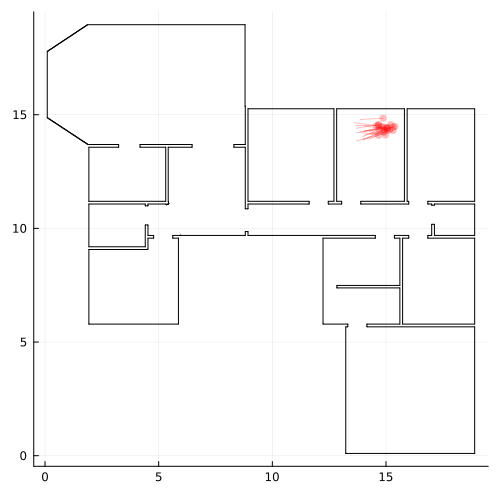

In [11]:
ps = [pose_prior_model(_ps[1]) for t=1:20]
# -----------------
myplot = plot(size=(500,500), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
scatter!.(ps, alpha=0.25)
myplot

## Motion model

In [12]:
#nbx
"""
    p′ = motion_model(p, u, x_noise=0.25, hd_noise=22.5)

Sample a new pose `p′` given the previous pose `p`, 
some control data `u = (dx, dhd)`, and noise levels
`x_noise` and `hd_noise` (in degrees).
"""
@gen function motion_model(p, u, x_noise=0.25, hd_noise=22.5)
    dx, dhd = u
    x   ~ diagnormal(p.x  + dx , [x_noise, x_noise])
    hd  ~ normal(p.hd + dhd, hd_noise/360*π)
    return p = Pose(x, hd)
end;

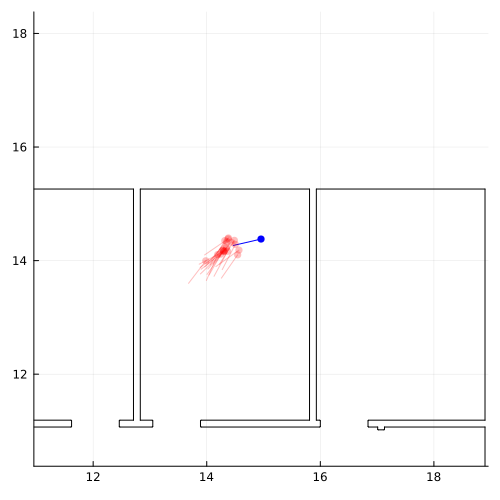

In [13]:
x_noise  = 0.1
hd_noise = 22.5;
t = 1
p = _ps[t]

ps = [motion_model(p, _us[1], x_noise, hd_noise) for t=1:20]
# -----------------
myplot = plot(size=(500,500), 
    xlim=(p.x[1]-4, p.x[1]+4), 
    ylim=(p.x[2]-4, p.x[2]+4),
    aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
scatter!(p, r=0.5, c=:blue)
scatter!.(ps, r=0.5, alpha=0.25)
myplot

## Sensor model 

The sensor model is the only part that depends on the map.
Since in this notebook we are only concerned with localization, not mapping,
we assume we are given a map of the environment. In this notebook the map is a
bunch of line segments stored in `_segs`.

### Raycaster - GPU

In [14]:
include("src/cuda_raycaster_line_map.jl");
display(@doc cast_v4!);

```
cast_v4!(X, P, Z; blockdims=(16,16))
```

Takes array of `n` stacked segments `X` and `m` stacked poses `P` and an observation array `Z` of shape `(n,m,k)` and fills it with depth measurements along angles `range(-π,π,k+1)[1:end-1]`.

Example:

```julia
n = 1000 # num segments
m =  500 # num poses

x = rand(n, 4)
p = zeros(m, 3)
z = ones(m, n, 360)

x_ = CuArray(x)
z_ = CuArray(z)
p_ = CuArray(p)

z′ = cast_v4!($x_,$p_,$z_; blockdims=(16,16))
```

Runtimes:

```julia
`cast_v4!` GPU vs CPU
x: (1000, 4), a: (360,), p: (1, 3)
data: (1000, 1), block: (16, 16), grid: (63, 1)
>>  218.122 μs (64 allocations: 3.50 KiB)

`cast_v4!` GPU vs CPU
x: (500, 4), a: (360,), p: (500, 3)
data: (500, 500), block: (16, 16), grid: (32, 32)
>>  2.516 ms (105 allocations: 6.16 KiB)
```


In [15]:
_as[1]/π == - _as[end]/π, 
length(_as),
_zs[1][1] == _zs[1][end]

(false, 360, false)

In [16]:
r = rand(500,500,360)

@btime      CuArray($r) samples=3 evals=3;
@btime      CuArray{Float64}(undef, 500,500,360) samples=3 evals=3;
@btime Inf.*CuArray{Float64}(undef, 500,500,360) samples=4 evals=4;
@btime Inf *CuArray{Float64}(undef, 500,500,360) samples=4 evals=4;
@btime Inf.*CUDA.ones(500,500,360) samples=4 evals=4;
@btime Inf *CUDA.ones(500,500,360) samples=4 evals=4;

  90.400 ms (4 allocations: 176 bytes)
  4.282 μs (4 allocations: 176 bytes)
  15.979 μs (36 allocations: 2.14 KiB)
  17.535 μs (36 allocations: 2.14 KiB)
  22.967 μs (38 allocations: 2.17 KiB)
  21.678 μs (38 allocations: 2.17 KiB)


```julia
  87.553 ms (4 allocations: 186 bytes)
  4.739 μs (4 allocations: 176 bytes)
  16.071 μs (36 allocations: 2.14 KiB)
  16.184 μs (36 allocations: 2.14 KiB)
  22.893 μs (38 allocations: 2.17 KiB)
  22.505 μs (38 allocations: 2.17 KiB)
```

In [17]:
segs_ = CuArray(stack(Vector.(_segs)))

function cast_GPU(ps; blockdims=(16,16))
    n = size(segs_, 1)    
    m = length(ps)
    
    p_ = CuArray(stack(Vector.(ps)))
    z_ = Inf*CUDA.ones(m,n,360)
    
    datadims  = (n,m)
    z′ = cast_v4!(segs_,p_,z_; blockdims=(16,16))
    
    return z′
end

cast_GPU (generic function with 1 method)

 Inf's: 138


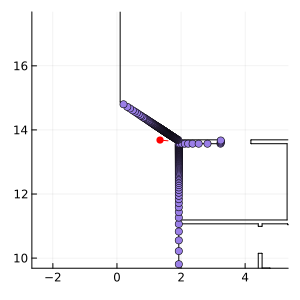

In [207]:
t  = rand(1:length(ps))
z_ = cast_GPU(ps)
z = Array(z_)

println(" Inf's: $(sum(z[t,:] .== Inf ))")

p = ps[t]

ys = [p.x] .+ polar_inv(z[t,:], _as .+ p.hd)
# ------
myplot = plot(size=(300,300), 
    xlim=(p.x[1]-4, p.x[1]+4), 
    ylim=(p.x[2]-4, p.x[2]+4),
    aspect_ratio=:equal, 
    legend=nothing)
plot!(_segs, c=:black)
scatter!(ys)
scatter!(p, r=0.25)

#### Benchmark

In [164]:
p = pose_prior_model()
ps = [pose_prior_model() for t=1:500];

@btime cast_GPU($([p])) samples=5 evals=5;
@btime cast_GPU($ps)    samples=5 evals=5;

  186.188 μs (176 allocations: 8.92 KiB)
  3.346 ms (769 allocations: 73.43 KiB)


```julia
>> 186.188 μs (176 allocations: 8.92 KiB)
>>   3.346 ms (769 allocations: 73.43 KiB)
```

In [20]:
@btime circshift($z_, 2) samples=2 evals=2;
@btime circshift($z, 1) samples=2 evals=2;

  50.419 μs (75 allocations: 3.64 KiB)
  261.012 μs (2 allocations: 1.37 MiB)


### Sensor model - v1 - Single Gaussian

Each observation entry is a measurement $(z_i,a_i)$ that we interpret as a point $x_i = z_i \cdot e^{i a_i}$ in the euclidean plane....
$$
    P(x| p, M) = \prod_i f(x_i ; p, a_i, M)
$$
Each sampled from a single 2d-Gaussian or "anywhwere" cmoputed from depth measurement along its respective angle...
window of size 1...

In [191]:
gaussian_or_anywhere = HeterogeneousMixture([diagnormal, anywhere])
sensor_dist = ProductDistribution(gaussian_or_anywhere)


dropout = 0.1
args = ([1-dropout,dropout], zeros(2),ones(2))

x = gaussian_or_anywhere(args...)
@btime gaussian_or_anywhere(args...)          samples=3 evals=3;
@btime logpdf(gaussian_or_anywhere,x,args...) samples=3 evals=3;

  1.452 μs (6 allocations: 352 bytes)
  2.745 μs (16 allocations: 704 bytes)


```julia
>>  1.452 μs (6 allocations: 352 bytes)
>>  2.745 μs (16 allocations: 704 bytes)
```

In [22]:
@gen function sensor_model_v0(p, std, dropout)
        z_gpu = cast_GPU([p])
        z′ = Array(z_gpu[1,:])
        y′ = polar_inv(z′,_as)
    
        n = length(y′)
        args = (fill([1-dropout,dropout], n), y′, std*ones(n,2))
        y ~ sensor_dist(args...)
    
        return y, y′
end;

In [23]:
"""
    y, y′ = sensor_model_v1(p, s_noise, dropout)
"""
@gen function sensor_model_v1(p, s_noise, dropout)
        z_gpu = cast_GPU([p])
        z′ = Array(z_gpu[1,:])
        y′ = polar_inv(z′,_as)
    
        n = length(y′)
    
        y = Vector{Vector{Float64}}(undef, n)
        for i=1:n
            y[i] = {:y => i} ~ gaussian_or_anywhere([1-dropout,dropout], y′[i], [s_noise;s_noise])
        end
    
        return y, y′
end;

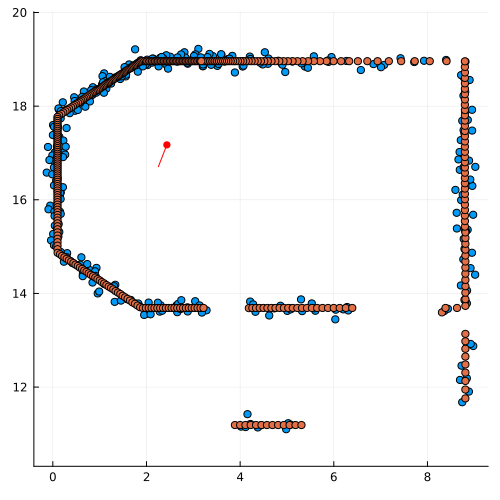

In [26]:
t = rand(1:length(ps))
sensor_noise = 0.1
dropout      = 0.1
args = (ps[t], sensor_noise, dropout)
tr = simulate(sensor_model_v1, args);
y, y′ = get_retval(tr)
p, = get_args(tr)

# ------
myplot = plot(size=(500,500), aspect_ratio=:equal, legend=nothing)
# plot!(_segs, c=:black)
scatter!(y.*p)
scatter!(y′.*p)
scatter!(p, r=0.5)

#### Benchmark

In [27]:
args = (_ps[1], sensor_noise, dropout)
ch = choicemap([(:y => i) => yi for (i,yi) in enumerate(polar_inv(_zs[1],_as))]...)
@btime sensor_model_v1(args...)               samples=3 evals=3;
@btime simulate($sensor_model_v1, $args)      samples=5 evals=5;
@btime generate($sensor_model_v1, $args, $ch) samples=5 evals=5;

  551.800 μs (3077 allocations: 193.17 KiB)
  1.274 ms (9380 allocations: 475.74 KiB)
  1.508 ms (10141 allocations: 448.88 KiB)



```julia
sensor_model_v1
>>  491.079 μs (3035 allocations: 197.17 KiB)
>>    1.448 ms (9333 allocations: 479.57 KiB)
>>    1.649 ms (10096 allocations: 452.77 KiB)
```

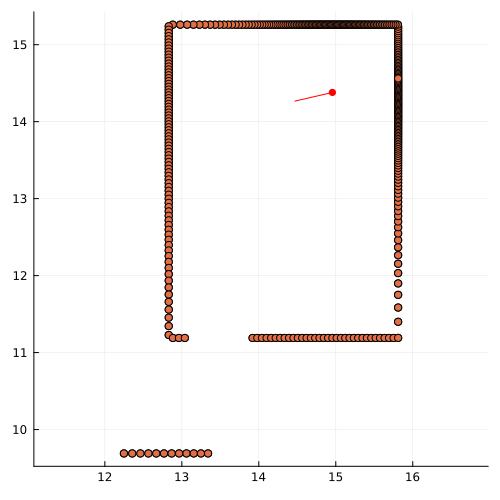

In [28]:
tr,w = generate(sensor_model_v1, args, ch);
y, y′ = get_retval(tr)
p, = get_args(tr)
# ------
myplot = plot(size=(500,500), aspect_ratio=:equal, legend=nothing)
# plot!(_segs, c=:black)
scatter!(y.*p)
scatter!(y′.*p)
scatter!(p, r=0.5)

### Sensor model - v2 - Full Mixture

Consider each observation point as an independent sample from a mixture of gaussians whose
centers are computed from range measurement in the known map....

In [29]:
gaussian_mixture = HomogeneousMixture(diagnormal, [1,1])

HomogeneousMixture{Vector{Float64}}(GenDistributionZoo.DiagonalNormal(), [1, 1])

In [208]:
n = 360
gm_test_args(n) = (
    ones(n)/n,  # mixture weights
    zeros(2,n), # means
    ones(2,n))  # cov

args = gm_test_args(n)

x = gaussian_mixture(args...)
for n = 1:50:360
    args = gm_test_args(n)
    @btime logpdf(gaussian_mixture,$x,$args...) samples=1 evals=1;
end

  34.000 μs (29 allocations: 1008 bytes)
  118.502 μs (979 allocations: 32.72 KiB)
  226.419 μs (1929 allocations: 64.36 KiB)
  319.337 μs (2879 allocations: 96.19 KiB)
  413.907 μs (3829 allocations: 127.97 KiB)
  526.550 μs (4779 allocations: 159.52 KiB)
  587.316 μs (5729 allocations: 191.11 KiB)
  703.126 μs (6679 allocations: 222.70 KiB)


`logpdf` evals are linear in the number of gaussians
```julia
n=1   >>   34.000 μs (29 allocations: 1008 bytes)
      >>  118.502 μs (979 allocations: 32.72 KiB)
      >>  226.419 μs (1929 allocations: 64.36 KiB)
      >>  319.337 μs (2879 allocations: 96.19 KiB)
      >>  413.907 μs (3829 allocations: 127.97 KiB)
      >>  526.550 μs (4779 allocations: 159.52 KiB)
      >>  587.316 μs (5729 allocations: 191.11 KiB)
n=350 >>  703.126 μs (6679 allocations: 222.70 KiB)
````

For `360` observations and `1000` particles this
takes far too long
```julia
N = 1000
703.126 * 360 / 1e6      * N, # ~253 seconds
703.126 * 360 / 1e6 / 60 * N  # ~4.2 mins
```

In [184]:
gaussian_mixture_or_anywhere = HeterogeneousMixture([gaussian_mixture, anywhere])
product_gm_or_anywhere = ProductDistribution(gaussian_mixture_or_anywhere)

n = 360
ws   = ones(n)/n
xs   = zeros(2,n)
stds = ones(2,n)

args = (ws, xs, stds)
dropout = 0.2

gaussian_mixture_or_anywhere

@btime gaussian_mixture_or_anywhere([1-dropout,dropout],$args...) samples=5 evals=5;
@btime begin
    for i=1:n
        gaussian_mixture_or_anywhere([1-dropout,dropout],$args...)
    end
end samples=3 evals=3;
@btime begin
    product_gm_or_anywhere(fill([1-dropout,dropout],n),fill(ws,n),fill(xs,n),fill(stds,n))
end samples=3 evals=3;

  3.417 μs (15 allocations: 1.87 KiB)
  1.906 ms (8887 allocations: 1.17 MiB)
  1.388 ms (6719 allocations: 1.07 MiB)


```julia
>>  3.417 μs (15 allocations: 1.87 KiB)
>>  1.906 ms (8887 allocations: 1.17 MiB)
>>  1.388 ms (6719 allocations: 1.07 MiB)
```

In [185]:
@btime ones(n)/n;
@btime fill(1/n,n);
@btime repeat([1/n], n);

  1.664 μs (2 allocations: 5.88 KiB)
  784.859 ns (2 allocations: 2.95 KiB)
  2.652 μs (3 allocations: 3.02 KiB)


Quickest way to get mixture weights
```julia
ones   >>   1.645 μs (2 allocations: 5.88 KiB)
fill   >> 791.652 ns (2 allocations: 2.95 KiB)
repeat >>   2.711 μs (3 allocations: 3.02 KiB)
```

In [170]:
p = pose_prior_model()
@btime begin 
    z_gpu = cast_GPU([p]) # ~ 186.188 μs 
    z′ = Array(z_gpu[1,:])
    y′ = polar_inv(z′,_as)
    hstack(y′)
end samples=2 evals=2;

  329.700 μs (587 allocations: 50.73 KiB)


In [171]:
"""
    y, y′ = sensor_model_v2(p, s_noise, dropout)
"""
@gen function sensor_model_v2(p, std, dropout)
        z_gpu = cast_GPU([p]) # ~ 186.188 μs 
        z′ = Array(z_gpu[1,:])
        y′ = polar_inv(z′,_as)
    
        n = length(y′)
    
        y = Vector{Vector{Float64}}(undef, n)
        args = (
            [1-dropout,dropout], 
            fill(1/n,n), 
            hstack(y′), 
            std*ones(2,n) 
        )
    
        for i=1:n
            y[i] = {:y => i} ~ gaussian_mixture_or_anywhere(args...) # ~ 5.167 μs
        end
    
        return y, y′
end;

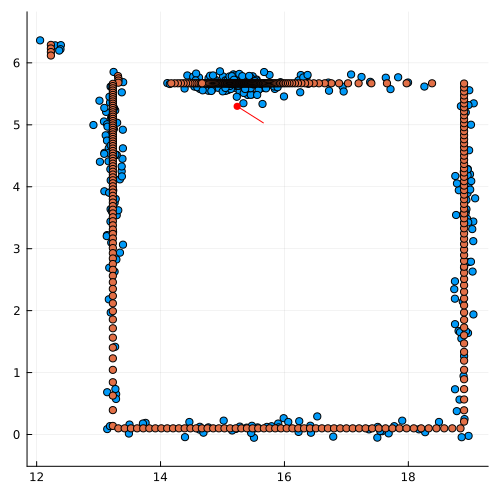

In [172]:
t = rand(1:length(ps))
sensor_noise = 0.1
dropout      = 0.1
args = (ps[t], sensor_noise, dropout)
tr = simulate(sensor_model_v2, args);
y, y′ = get_retval(tr)
p, = get_args(tr)

# ------
myplot = plot(size=(500,500), aspect_ratio=:equal, legend=nothing)
# plot!(_segs, c=:black)
scatter!(y.*p)
scatter!(y′.*p)
scatter!(p, r=0.5)

#### Benchmark

In [189]:
args = (_ps[1], sensor_noise, dropout)
ch = choicemap([(:y => i) => yi for (i,yi) in enumerate(polar_inv(_zs[1],_as))]...)

@btime sensor_model_v2(args...)               samples=5 evals=5;
@btime simulate($sensor_model_v2, $args)      samples=5 evals=5;
@btime generate($sensor_model_v2, $args, $ch) samples=5 evals=5;

  1.843 ms (8728 allocations: 1.27 MiB)
  235.098 ms (2481069 allocations: 81.75 MiB)
  230.960 ms (2475428 allocations: 80.71 MiB)


```julia
sensor_model_v2
>>    5.225 ms (10512 allocations: 8.39 MiB)
>>  254.350 ms (2482788 allocations: 88.85 MiB)
>>  251.563 ms (2477191 allocations: 87.82 MiB)
```

This is **NOT** usable:
`1000` generations take `~4min`

### Sensor model - v3 - Full mixture as product

In [186]:
"""
    y, y′ = sensor_model_v2(p, s_noise, dropout)
"""
@gen function sensor_model_v3(p, std, dropout)
        z_gpu = cast_GPU([p]) # ~ 186.188 μs 
        z′ = Array(z_gpu[1,:])
        y′ = polar_inv(z′,_as)
    
        n = length(y′)
        
        weights = fill(1/n,n)
        means = hstack(y′)
        stds = std*ones(2,n)  
        
        y ~ product_gm_or_anywhere(
                fill([1-dropout,dropout], n),
                fill(weights, n),
                fill(means, n),
                fill(stds,n))
    
        return y, y′
end;

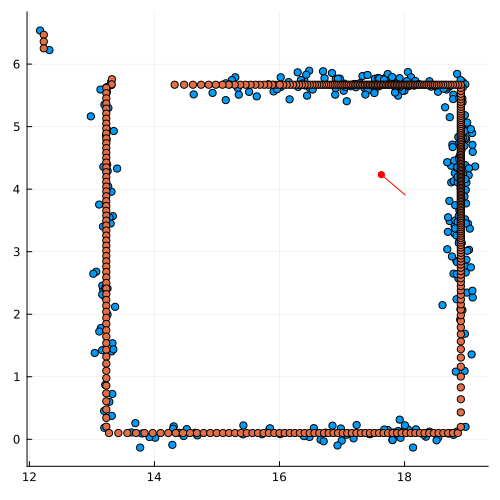

In [187]:
t = rand(1:length(ps))
sensor_noise = 0.1
dropout      = 0.1
args = (ps[t], sensor_noise, dropout)
tr = simulate(sensor_model_v3, args);
y, y′ = get_retval(tr)
p, = get_args(tr)

# ------
myplot = plot(size=(500,500), aspect_ratio=:equal, legend=nothing)
# plot!(_segs, c=:black)
scatter!(y.*p)
scatter!(y′.*p)
scatter!(p, r=0.5)

In [188]:
args = (_ps[1], sensor_noise, dropout)
ch = choicemap(:y => polar_inv(_zs[1],_as))

@btime sensor_model_v3(args...)               samples=3 evals=3;
@btime simulate($sensor_model_v3, $args)      samples=5 evals=5;
@btime generate($sensor_model_v3, $args, $ch) samples=5 evals=5;

  1.876 ms (8058 allocations: 1.26 MiB)
  231.101 ms (2479063 allocations: 81.64 MiB)
  229.171 ms (2471672 allocations: 80.57 MiB)


### GPU Accelerated Gaussian Mixture

In [350]:
m = 350 # num mixture components
n = 350 # num observations

sig = 1.0
mu  = zeros(m,2) 
x   = rand(n,2)

mu_ = CuArray(mu)
x_  = CuArray(x)


function gm_product_logpdf(x, mu, sig)
    m = size(mu,1)
    n = size(x,1)
    
    x  = reshape( x, n,1,2)
    mu = reshape(mu, 1,m,2)
    
    d = (x .- mu).^2 ./ sig^2
    log_p = -log(sqrt(sig * 2 * π)) .- 1/2 * d
    log_p = sum(log_p, dims=3) 
    p = sum(exp.(log_p .- log(m)), dims=2)
    log_p = log.(p) 
    return sum(log_p, dims=1)[1,1,1]
end


function gm_product_logpdf_gpu(x, mu, sig)
    # This makes it GPU/CUDA accelerated
    x  = CuArray(x)
    mu = CuArray(mu)
    
    return gm_logpdf(x, mu, sig)
end


@btime gm_product_logpdf($x, $mu, $sig) samples=3 evals=3;
@btime gm_product_logpdf_gpu($x, $mu, $sig) samples=3 evals=3;

  3.805 ms (28 allocations: 7.48 MiB)
  208.146 μs (291 allocations: 19.06 KiB)


```julia
CPU      >>   4.521 ms (28 allocations: 7.48 MiB) 
GPU CUDA >> 203.800 μs (293 allocations: 19.16 KiB)
```

Reatlity check:

In [392]:
gm = HomogeneousMixture(diagnormal, [1,1])
gm_product= ProductDistribution(gm)

gm_args(m) = (
    ones(m)/m,  # mixture weights
    zeros(2,m), # means
    ones(2,m))  # cov

gm_product_args(m,n) = Tuple([fill(a,n) for a in gm_args(m)])


m = rand(1:100)
n = rand(1:100)

args = gm_product_args(m,n)
x = gm_product(args...)

print("""
    m = $(m)
    n = $(n)     
""")

isapprox(
    logpdf(gm_product, x, args...),
    gm_product_logpdf_gpu(stack(x), zeros(m,2), 1.0)
)

    m = 33
    n = 48     


true

In [393]:
#nbx
struct GaussianMixtureProductGPU <: Distribution{Vector{Vector{Float64}}} 
    n::Int
end

Gen.logpdf(::GaussianMixtureProductGPU, x::Matrix{Float64}, mu::Matrix{Float64}, sig::Float64) = gm_product_logpdf_gpu(x, mu, sig)
function Gen.random(GMP::GaussianMixtureProductGPU, mu::Matrix{Float64}, sig::Float64)
    n = GMP.n
    return [dianormal(x,[sig;sig]) for x in eachrow(mu)]
end

(GMP::GaussianMixtureProductGPU)(args...) = Gen.random(GMP, args...)
Gen.has_output_grad(::GaussianMixtureProductGPU)    = false
Gen.has_argument_grads(::GaussianMixtureProductGPU) = (false, false);

#### Benchmark

In [396]:
for (m,n) in [(360, 1), (360,360), (10, 360)]

    args = gm_product_args(m,n)
    x = gm_product(args...)

    gm_product_gpu = GaussianMi   xtureProductGPU(n)
    
    println("\nMixture comp => $(m), Product factors => $(n)")
    @btime logpdf(gm_product, x, args...) samples=3 evals=3;
    @btime logpdf(gm_product_gpu, stack(x), zeros(m,2), 1.0) samples=3 evals=3;
    @btime gm_product_logpdf_gpu(stack(x), zeros(m,2), 1.0) samples=3 evals=3;
    
end


Mixture comp => 360, Product factors => 1
  625.356 μs (6860 allocations: 228.81 KiB)
  202.007 μs (296 allocations: 20.02 KiB)
  199.557 μs (297 allocations: 20.03 KiB)

Mixture comp => 360, Product factors => 360
  222.531 ms (2466010 allocations: 80.29 MiB)
  219.753 μs (301 allocations: 28.64 KiB)
  221.828 μs (302 allocations: 28.66 KiB)

Mixture comp => 10, Product factors => 360
  6.333 ms (72010 allocations: 2.36 MiB)
  225.483 μs (301 allocations: 28.64 KiB)
  223.832 μs (302 allocations: 28.66 KiB)


Number of factors `n` in the product correspond to the number of measurements we are evaluating.

```julia
Mixture comp => 360, Product factors => 1
  623.710 μs (6860 allocations: 228.81 KiB)
  204.041 μs (299 allocations: 25.20 KiB)
  204.085 μs (300 allocations: 25.22 KiB)

Mixture comp => 360, Product factors => 360
  221.891 ms (2466010 allocations: 80.29 MiB)
  232.343 μs (294 allocations: 33.50 KiB)
  230.355 μs (295 allocations: 33.52 KiB)

Mixture comp => 10, Product factors => 360
  6.370 ms (72010 allocations: 2.36 MiB)
  227.365 μs (294 allocations: 33.50 KiB)
  225.339 μs (295 allocations: 33.52 KiB)
```

#### Can we use it actually

## SLAM Model

General structure:
```julia
motion_model(p::Pose, u::Control, motion_args...)
sensor_model(p::Pose, m::MAP, sensor_args...)
```
Here:
```julia
sensor_model(p::Pose, sensor_args...)
```

In [256]:
@doc motion_model

```
p′ = motion_model(p, u, x_noise=0.25, hd_noise=22.5)
```

Sample a new pose `p′` given the previous pose `p`,  some control data `u = (dx, dhd)`, and noise levels `x_noise` and `hd_noise` (in degrees).


In [265]:
@doc sensor_model_v1

```
y, y′ = sensor_model_v1(p, s_noise, dropout)
```


In [266]:
@doc sensor_model_v2

```
y, y′ = sensor_model_v2(p, s_noise, dropout)
```


In [35]:
#nbx
@gen function slam_kernel_v1(t, state, us, x_noise, hd_noise, s_noise, dropout)
    
        p,_ = state
        u = us[t]
    
        p  = {:pose}   ~ motion_model(p, u, x_noise, hd_noise)
        y, = {:sensor} ~ sensor_model_v1(p,  s_noise, dropout) # GPU accelerated
        
    return (p, y)
end

slam_chain_v1 = Gen.Unfold(slam_kernel_v1)
Gen.@load_generated_functions

In [36]:
#nbx
@gen function slam_kernel_v2(t, state, us, x_noise, hd_noise, s_noise, dropout)
    
        p,_ = state
        u = us[t]
    
        p  = {:pose}   ~ motion_model(p, u, x_noise, hd_noise)
        y, = {:sensor} ~ sensor_model_v2(p,  s_noise, dropout) # GPU accelerated
        
    return (p, y)
end

slam_chain_v2 = Gen.Unfold(slam_kernel_v2)
Gen.@load_generated_functions

In [347]:
@doc pose_prior_model

```
p = pose_prior_model(p=nothing, x_noise=0.25, hd_noise=22.5)
```


In [37]:
#nbx
"""
    [(p,z),...] = static_slam_model(T, segs_, a_, us, motion_noise, sensor_noise, dropout, inds)

Static SLAM model ...
"""
@gen (static) function static_slam_model_v1(T, us, 
        p0, x0_noise, hd0_noise,  
        x_noise, hd_noise, 
        s_noise, dropout)
    
    # Start the Markov chain; 
    # No motion, just the prior
    p  = { :pose   } ~ pose_prior_model(p0, x0_noise, hd0_noise)
    y, = { :sensor } ~ sensor_model_v1(p, s_noise, dropout) # GPU accelerated
    
    # Unfold the MArkov chain
    chain ~ slam_chain_v1(T, (p, nothing), us, x_noise, hd_noise, s_noise, dropout)
    
    return [(p,y);chain]
end

Gen.@load_generated_functions

In [39]:
#nbx
"""
    [(p,z),...] = static_slam_model(T, segs_, a_, us, motion_noise, sensor_noise, dropout, inds)

Static SLAM model ...
"""
@gen (static) function static_slam_model_v2(T, us, 
        p0, x0_noise, hd0_noise,  
        x_noise, hd_noise, 
        s_noise, dropout)
    
    # Start the Markov chain; 
    # No motion, just the prior
    p  = { :pose   } ~ pose_prior_model(p0, x0_noise, hd0_noise)
    y, = { :sensor } ~ sensor_model_v2(p, s_noise, dropout) # GPU accelerated
    
    # Unfold the MArkov chain
    chain ~ slam_chain_v2(T, (p, nothing), us, x_noise, hd_noise, s_noise, dropout)
    
    return [(p,y); chain]
end

Gen.@load_generated_functions

```julia

    prior     chain 
     0          1        2          t-1

               u[1] --- u[2]  ...  u[t-1]
                |        |          |
    p[1] - - - p[2] --- p[3]  ...  p[t]
     |          |        |          |
    y[1]       y[2]     y[3]  ...  y[t] 
```

In [40]:
foldr(=>,[:x, :y, :z]) 

:x => (:y => :z)

In [143]:
get_pose(tr,t) = tr[][t][1]
get_first_pose(tr) = get_pose(tr,1)

get_first_pose (generic function with 1 method)

In [ ]:
function Plots.plot!(p::Pose; r=0.5, args...)
    plot!([p.x, p.x + r*unit_vec(p.hd)]; args...)
end

function Plots.plot!(ps::Vector{Pose}, cs::Vector{RGBA{Float64}}; r=0.5, args...)
    for (p,c) in zip(ps,cs)
        plot!([p.x, p.x + r*unit_vec(p.hd)];c=c, args...)
    end
end

In [52]:
function constraints(t::Int)
    ch = choicemap()
    if t==0
        addr  = [:sensor, :y]
    else
        addr  = [:chain, t, :sensor, :y]
    end
    n = length(_zs[t+1])
    ys = polar_inv(_zs[t+1],_as)
    for i=1:n
        ch[foldr(=>,[addr;i])] = ys[i]
    end
    return ch
end

constraints (generic function with 1 method)

In [150]:
T = 0

p0 = _ps[1]
x0_noise = 0.2
hd0_noise = 15.

x_noise = 0.1
hd_noise = 5.

s_noise = 0.1
dropout = 0.1

ch = constraints(0)
args = (
    T, _us,         
    p0, x0_noise, hd0_noise, # Pose prior model
    x_noise, hd_noise,       # Motion model
    s_noise, dropout         # Sensor model
)

tr,w = generate(static_slam_model_v1, args, ch);

In [156]:
N = 500
trs, ws, lml = importance_sampling(static_slam_model_v2, args, ch, N);

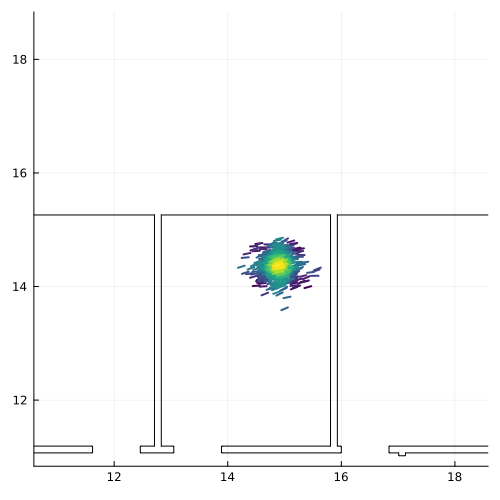

In [157]:
perm = sortperm(ws); trs = trs[perm]; ws = ws[perm];
p = ps[1]
ps = get_pose.(trs, 1)
cs = peak_to_peak(ws)
# ------
myplot = plot(size=(500,500),
    xlim=(p.x[1]-4, p.x[1]+4), 
    ylim=(p.x[2]-4, p.x[2]+4),
    aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
# scatter!(y.*p)
plot!(ps, cgrad(:viridis)[cs], r=0.125, linewidth=2)
myplot